In [1]:
# INITIALIZATION:  initialize subpopulations to cover different parts of the search space
# MIGRATION: let it occur randomly. individuals are chosen at random to migrate to a random destination
#             OR tournament selection can be used
#             OR something like proportional selection, where "immigrants" are accepted based on the proportion
#             of its fitness compared to that of the destination island


In [2]:
%matplotlib notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from copy import deepcopy

# Create chromosome blueprint, initialize the population, and create a way to display
# the population

class Chromosome:
    
    def __init__(self, genes = None, min_range = None, max_range = None):
        
        if(genes == None):
            x = np.random.randint(min_range, max_range)
            y = np.random.randint(min_range, max_range)
            
        else:
            x = genes["x"]
            y = genes["y"]
    
        #self.genes = {"x": x}
        self.genes = {"x": x, "y": y}
        
        self.fitness = None
        
def create_population(num_chromosomes, min_range, max_range):
    
    population = []
    for i in range(num_chromosomes):
        population.append(Chromosome(min_range = min_range, max_range = max_range))
    return population 

def display_population(population, string):
    
    print(f"\nPopulation after {string}:\n")
    for i, chromosome in enumerate(population):
        print("Chromosome %s : x = %s, y = %s, fitness = %s" 
              % (i, chromosome.genes["x"], chromosome.genes["y"], chromosome.fitness))

# maps a chromosome representation into a scalar value

def fitness(x, y):
    
    #x^2
    #return (x ** 2)
    
    #Matyas Function
    return (x ** 2 + y ** 2) * 0.26 - (x * y) * 0.48
    
    #Himmelblau's Function
    #return (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2
    
    #Ackley function
    #return( -20 * np.exp(-0.2 * np.sqrt(0.5 * (x ** 2 + y ** 2))) - np.exp(0.5*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y))) - np.e + 20)
# Create function to update each chromosome's fitness

def evaluate_population(population):

    for chromosome in population:
        chromosome.fitness = fitness(chromosome.genes["x"], chromosome.genes["y"])
        
    scores = [chromosome.fitness for chromosome in population]
    
    indices = np.argsort(scores) #this sorts each row from greatest to least and creates a list of indices
    
    return list(np.asarray(population)[indices])

# Create selection function(s). this is the function that chooses parents to reproduce.


def roulette_wheel(population, p_num_selected, epsilon = 1e-4, max_num_selected = 4):
    
    sum_of_fitnesses = calculate_sum_of_fitnesses(population)
    
    # calculate relative fitness. Roulette wheel made
    
    try:
        scores = [1 - (chromo.fitness / (sum_of_fitnesses + epsilon)) for chromo in population]
    except:
        from IPython import embed
        embed()

        
    # spin the created roulette wheel --> P selected chromosomes
    
    selected = []
    
    for i in range(p_num_selected):
        
        # If parent is already selected, pick another? 
        
        while(1):
            
            sigma = random.uniform(0, np.max(scores))

            total = 0
            for j in range(len(scores)):
                total = total + scores[j]
                if(total >= sigma):
                    break

            the_chosen = population[j]
            
            #print("Chosen: x = %s, y = %s" % (the_chosen.genes["x"], the_chosen.genes["y"]))

            # get number of times chosen has appeared in selected parents

            total = 0
            for chromosome in selected:
                if(the_chosen == chromosome):
                    total = total + 1
            
            if(total < max_num_selected):
                break  
            else:
                scores.pop(j)
                population.pop(j)
                 
        selected.append(the_chosen)
        #print("CHOSEN IS ADDED")

    return selected 

def calculate_sum_of_fitnesses(population):
    sum_of_fitnesses = 0
    for chromosome in population:
        sum_of_fitnesses += chromosome.fitness
    return sum_of_fitnesses

def create_matches(parent_group, req_num_parents):
    
    num_groups = int(len(parent_group) / req_num_parents)
    
    # get sets of subgroups that are going to produce one child
    
    couples = []
        
    for i in range(num_groups):
        
        # get the indices of parents for each subgroup 
        
        indices = [ np.random.randint(0, len(parent_group)) 
                    for j in range(req_num_parents) ]
        
        # populate subgroup with chromosomes 
        
        group = [parent_group[index] for index in indices]
        
        couples.append(group)
    
    return couples

def selection(population, elite_percent, req_num_parents = 2):
    
    parents = []
    
    if elite_percent > 0:
        
        elite_group = []
        
        num_chromosomes = len(population)
        e_num_selected = math.ceil(elite_percent * num_chromosomes) 
        
        # most elite chromos automatically get into next generation
        
        for i in range(e_num_selected):
            elite_group.append(population[i])
    
    else:
        elite_group = []
        e_num_selected = 0
        
    # build up the rest of the parents list using roulette wheel.
   
    num_chromosomes = len(population)
    p_num_selected = int((num_chromosomes - e_num_selected) * req_num_parents)
    
    parent_group = roulette_wheel(population, p_num_selected)
    
    parent_group = create_matches(parent_group, req_num_parents)

    return elite_group, parent_group

def calculate_mean(population):
    
    num_genes = len(population[-1].genes.keys())
    
    mean = np.zeros(num_genes)
    for chromosome in population:
        genes = chromosome.genes
        for i, current_gene in enumerate(genes.keys()):
            mean[i] += chromosome.genes[current_gene]
        
    return mean / len(population)
        
def simplex_crossover(parent_groups):
    
    children = []
    for parents in parent_groups:
    
        # select random parent for simplex equation 
        
        index = np.random.randint(0, len(parents))
        rand_chromo = parents[index]
        
        # get all possible genes
        
        all_genes = parents[-1].genes.keys()
        
        # run simplex on each gene
        
        simplexed_genes = {}
        for current_gene in all_genes:
            
            epsilon = np.random.rand()
            info = [chromo.genes[current_gene] for chromo in parents] 
            
            agg = math.ceil(np.mean(info) + (rand_chromo.genes[current_gene] - np.mean(info)) * epsilon)
            
            simplexed_genes[current_gene] = agg
        
        # create child from simplexed genes
        
        children.append(Chromosome(simplexed_genes))
    
    return children


def mutation(children, mutate_chance, mutate_scale = 0.5):
    
    kiddos = []
    
    for child in children:
        
        alpha = np.random.rand()
        
        # mutate if random allows 
        
        if(alpha <= mutate_chance):
            
            # mutate all child genes
            
            all_genes = child.genes.keys()
        
            for current_gene in all_genes:
                flip = -1 if(np.random.rand() >= 0.5) else 1
                offset = flip * child.genes[current_gene] * mutate_scale
                child.genes[current_gene] = math.ceil(child.genes[current_gene] + offset)
            
        kiddos.append(child)
    
    return kiddos 

def mutation_constant(population, generation):
    
    # the strategy is to decrease sigma as the number of generations increases so we get 
    # small variations near the optimum, preventing individuals from jumping over the 
    # minimum
    
    if generation >= num_generations * (3/4):
            sigma = 0.05
    elif generation < num_generations * (3/4) and generation >= num_generations / 2:
            sigma = 0.1
    elif generation < num_generations / 2 and generation >= num_generations / 4:
            sigma = 0.15
    elif generation < num_generations / 4:
            sigma = 0.2
            
    # each individual is mutated by adding a gaussian random value
    gaussian = random.uniform(0,sigma)
    # can I make this value hover around zero?
    #gaussian = random.uniform(-sigma,sigma)
    
    for chromosome in population:
        chromosome.genes["x"] = chromosome.genes["x"] + gaussian
        
    # evaluate fitness before returning
    evaluate_population(population)
    
    return population

# stats methods
def get_analytics(population):
    
    fitness = []
    for chromosome in population:
        fitness.append(chromosome.fitness)
    
    return np.max(fitness), np.min(fitness), np.mean(fitness), np.median(fitness)


In [2]:
# Create one iteration of GA cycle

def run_generation(pop, elite_percent, mutate_chance, mutate_percent):
    
    pop = evaluate_population(pop)
    
    maximum, minimum, average, median = get_analytics(pop)
    
    # Selection for children and optional elitism 
    
    elite_group, parent_group = selection(deepcopy(pop), elite_percent)
    
    # Create some kids, via cross-over / mutation 
    
    children = simplex_crossover(parent_group)
    
    #display_population(children, "children")
    
    children = mutation(children, mutate_chance, mutate_percent)
    
    #display_population(children,"mutation")
    
    # Update population for new generation 
    
    pop = elite_group + children
    
    return {"pop": pop, "min": minimum, "max": maximum, "avg": average, "med": median}

In [3]:
def evaluate_islands(all_islands, all_configs, num_islands):
    
    all_scores = []
    for j in range(num_islands):
        current_island = all_islands[j]
        current_island["pop"] = evaluate_population(current_island["pop"])
        minimum, maximum, average, median = get_analytics(current_island["pop"])
        all_scores.append(median)
        
    best_index, worst_index = np.argmax(all_scores), np.argmin(all_scores)
    best_island, worst_island = all_islands[best_index], all_islands[worst_index]
    best_config, worst_config = all_configs[best_index], all_configs[worst_index]
    
    return best_island, best_config, worst_island, worst_config

In [4]:
def remove_stragglers(pop, num_stragglers, alpha = 1e-4):
    
    return pop[:-num_stragglers]    

def add_migrants(pop, all_migrants):
    
    for migrant in all_migrants:
        pop.append(migrant)
    
    return pop

def update_population(pop, config, all_migrants):
    
    pop = deepcopy(pop)
    
    num_migrants = len(all_migrants)
    
    # Find location of migrants
    
    all_indices = []
    for migrant in all_migrants:
        for i, chromo in enumerate(pop):
            if(migrant == chromo):
                all_indices.append(i)
    
    # - Add new chromos
    
    min_range, max_range = config["min_range"], config["max_range"]
    
    for index in all_indices:
        pop[index] = Chromosome(min_range = min_range, max_range = max_range)
     
    return pop

In [5]:
# Create island configuration (params)
                    #Island 0: the "control" island
island_configs = [{"min_range": -5, "max_range": 5, 
                   "num_chromosomes": 20, "elite_percent": 0.1, "mutate_chance": 0.4, "mutate_percent": 0.5},
                  
                    #Island 1: the exploration island
                  {"min_range": -5, "max_range": 5, 
                   "num_chromosomes": 20, "elite_percent": 0, "mutate_chance": 1, "mutate_percent": 1},
                  
                    #Island 2: the exploitation island
                  {"min_range": -5, "max_range": 5, 
                   "num_chromosomes": 20, "elite_percent": 0.2, "mutate_chance": 0.1, "mutate_percent": 0.1}]

num_islands = len(island_configs)
num_generations = 50
num_migrants = 2
migration_rate = 5

# Create island population

all_islands = []

for i in range(num_islands):
    
    island = {}
    island["id"] = i
    island["fitness_min"] = []
    island["fitness_max"] = []
    island["fitness_avg"] = []
    island["fitness_med"] = []
    
    config = island_configs[i]
    num_chromosomes = config["num_chromosomes"]
    min_range, max_range = config["min_range"], config["max_range"]
    
    island["pop"] = create_population(num_chromosomes, min_range, max_range)
    
    all_islands.append(island)
    
# Train Island GA

for i in range(num_generations):
    
    # Train each island once 
    
    for j in range(num_islands):
        
        # current island is a population of a GA
            
        current_island = all_islands[j]
        config = island_configs[j]
        
        if(i == 0):
            current_island["orig_pop"] = deepcopy(current_island["pop"])
        
        #display_population(current_island["pop"], "Island %s" % (j))
        results = run_generation(current_island["pop"], config["elite_percent"], config["mutate_chance"], config["mutate_percent"])
        
        current_island["pop"] = results["pop"]
        current_island["fitness_min"].append(results["min"])
        current_island["fitness_max"].append(results["max"])
        current_island["fitness_avg"].append(results["avg"])
        current_island["fitness_med"].append(results["med"])  
    
    if(i % migration_rate == 0):
        
        # ****** Migration *******

        # Select best and worst island

        best_island, best_config, worst_island, _ = evaluate_islands(all_islands, island_configs, num_islands)

        # Selected individuals for migration (Move)

        migrants = roulette_wheel(deepcopy(best_island["pop"]), num_migrants, max_num_selected = 1)

        worst_island["pop"] = remove_stragglers(worst_island["pop"], len(migrants))
        worst_island["pop"] = add_migrants(worst_island["pop"], migrants)
        best_island["pop"] = update_population(best_island["pop"], best_config, migrants)
    

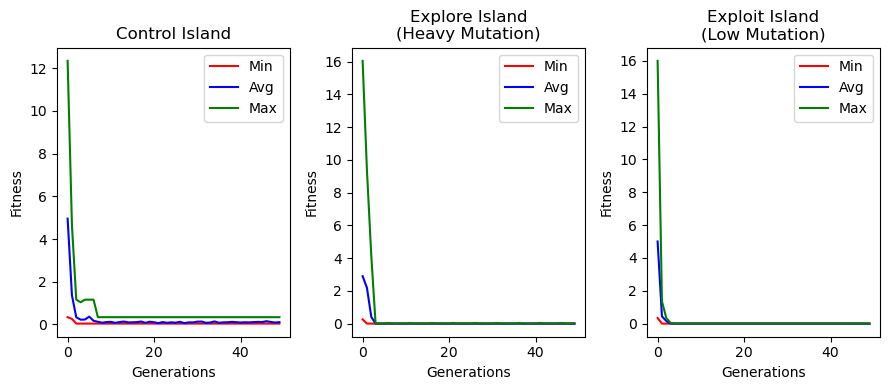

In [6]:
# Displaying results - first, performance graphs.

fig, ax = plt.subplots(1, num_islands, figsize = (9, 4))

for i in range(num_islands):
    current_island = all_islands[i]
    ax[i].plot(np.arange(0, num_generations, 1), current_island["fitness_min"], "r", label = "Min")
    ax[i].plot(np.arange(0, num_generations, 1), current_island["fitness_avg"], "b", label = "Avg")
    ax[i].plot(np.arange(0, num_generations, 1), current_island["fitness_max"], "g", label = "Max")
    ax[i].set_xlabel("Generations")
    ax[i].set_ylabel("Fitness")
    if i == 0:
        ax[i].set_title("Control Island")
    if i == 1:
        ax[i].set_title("Explore Island\n(Heavy Mutation)")
    if i == 2:
        ax[i].set_title("Exploit Island\n(Low Mutation)")
    ax[i].legend(loc = "upper right")
    
fig.tight_layout()

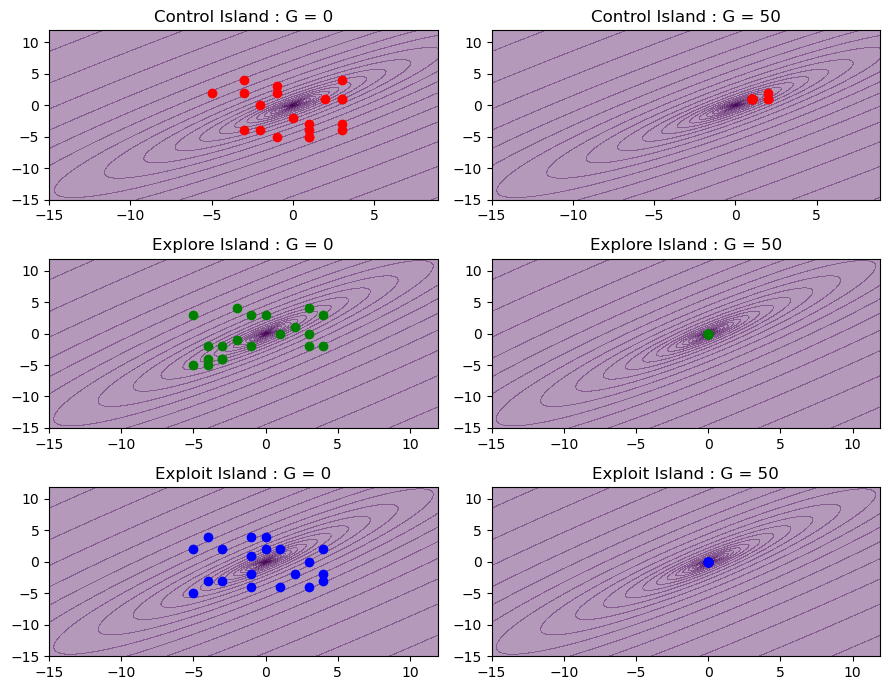

In [7]:
# Create world (meshgrid) for plotting known functions

def create_world(x_s, y_s, offset = 2, alpha = .1):

    min_x = np.min(x_s) + (offset * np.min(x_s))
    max_x = np.max(x_s) + (offset * np.max(x_s))
 
    min_y = np.min(y_s) + (offset * np.min(y_s))
    max_y = np.max(y_s) + (offset * np.max(y_s))


    x_vals = np.arange(min_x, max_x, alpha)
    y_vals = np.arange(min_y, max_y, alpha)

    xx, yy = np.meshgrid(x_vals, y_vals)

    zz = fitness(xx, yy)
    
    return xx, yy, zz

# Displaying results - second, lets display 2D world.

island_colors = ["red", "green", "blue"]

fig, ax = plt.subplots(num_islands, 2, figsize = (9, 7))

for i in range(num_islands):

    current_island = all_islands[i]
   
    # Gather population of interest (generation = start)
    
    orig_pop = current_island["orig_pop"]
        
    x_s_orig, y_s_orig = np.zeros(num_chromosomes), np.zeros(num_chromosomes)

    for j, chromosome in enumerate(orig_pop):
        x_s_orig[j] = chromosome.genes["x"]
        y_s_orig[j] = chromosome.genes["y"]

    # Gather population of interest (generation = end)

    pop = current_island["pop"]
    
    x_s_final, y_s_final = np.zeros(num_chromosomes), np.zeros(num_chromosomes)

    for j, chromosome in enumerate(pop):
        x_s_final[j] = chromosome.genes["x"]
        y_s_final[j] = chromosome.genes["y"]   

    # Plot 2D world

    xx, yy, zz = create_world(x_s_orig, y_s_orig)

    ax[i, 0].contourf(xx, yy, zz, levels = np.logspace(min_range, max_range, 50), alpha = 0.4)
    if i == 0:
        ax[i, 0].set_title("Control Island : G = 0",fontsize = 12)
    if i == 1:
        ax[i, 0].set_title("Explore Island : G = 0",fontsize = 12)
    if i == 2:
        ax[i, 0].set_title("Exploit Island : G = 0",fontsize = 12)
    ax[i, 0].scatter(x_s_orig, y_s_orig, c = island_colors[i])

    ax[i, 1].contourf(xx, yy, zz, levels = np.logspace(min_range, max_range, 50), alpha = 0.4)
    if i == 0:
        ax[i, 1].set_title("Control Island : G = %s" % num_generations,fontsize = 12)
    if i == 1:
        ax[i, 1].set_title("Explore Island : G = %s" % num_generations,fontsize = 12)
    if i == 2:
        ax[i, 1].set_title("Exploit Island : G = %s" % num_generations,fontsize = 12)
    ax[i, 1].scatter(x_s_final, y_s_final, c = island_colors[i])

fig.tight_layout()